In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from itertools import product
from math import sqrt
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn import preprocessing

%matplotlib inline

In [2]:
weather_df = pd.read_csv('dataset/seattleWeather_1948-2017.csv')
weather_df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [3]:
# check if there is any invalid field in the dataset
weather_df.isnull().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [8]:
weather_df[(pd.isnull(weather_df.PRCP))|(pd.isnull(weather_df.RAIN))]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


We have 2 options for these missing values:
1. Drop them
2. Infer them from its neighbors
In most cases, we should just drop them. Since I do plan to do TS forecasting, and to avoid temporal discontinuity, I will interpolate them from its neighbors.

In [9]:
# Let's take a look at the values surround the missing values and see if we can infer from its neighbors.
weather_df[18413:18418]

,DATE,PRCP,TMAX,TMIN,RAIN
18413,1998-05-31,0.0,73,48,False
18414,1998-06-01,0.0,62,51,False
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
18417,1998-06-04,0.0,60,53,False


In [10]:
weather_df[21064:21070]

,DATE,PRCP,TMAX,TMIN,RAIN
21064,2005-09-02,0.0,72,54,False
21065,2005-09-03,0.0,71,53,False
21066,2005-09-04,0.0,68,53,False
21067,2005-09-05,NaN,70,52,NaN
21068,2005-09-06,0.0,73,52,False
21069,2005-09-07,0.0,77,52,False


In [12]:
values = {'PRCP':0., 'RAIN': False}
weather_df.fillna(value=values, inplace=True)
weather_df.isnull().sum()

DATE    0
PRCP    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

Now the missing values are fixed.

In [13]:
# Check, convert datatypes and check value ranges for all columns
weather_df['TMAX'] = np.float64(weather_df['TMAX'])
weather_df['TMIN'] = np.float64(weather_df['TMIN'])
weather_df['PRCP'] = np.float64(weather_df['PRCP'])
# weather_df.set_index('DATE', inplace=True)


In [25]:
labelencoder = preprocessing.LabelEncoder()
weather_df['RAIN'] = labelencoder.fit_transform(weather_df['RAIN'])

In [17]:
# Extract a few more features that may be useful.
weather_df['MONTH'] = pd.DatetimeIndex(weather_df['DATE']).month
weather_df['DAY'] = pd.DatetimeIndex(weather_df['DATE']).day
weather_df.head()

,DATE,PRCP,TMAX,TMIN,RAIN,MONTH,DAY
0,1948-01-01,0.47,51.0,42.0,1,1,1
1,1948-01-02,0.59,45.0,36.0,1,1,2
2,1948-01-03,0.42,45.0,35.0,1,1,3
3,1948-01-04,0.31,45.0,34.0,1,1,4
4,1948-01-05,0.17,45.0,32.0,1,1,5


In [19]:
# Do a few more checks on the data to make sure there is no contradictory info.
assert len(weather_df[(weather_df.PRCP>0) & (weather_df.RAIN==False)])==0
assert len(weather_df[(weather_df.PRCP==0.) & (weather_df.RAIN==True)])==0
assert len(weather_df[weather_df['PRCP']<0])==0

In [20]:
# check if all data samples are evenly spaced since this is important for TS predicction
weather_df.index=pd.DatetimeIndex(pd.to_datetime(weather_df['DATE'], format='%Y-%m-%d'))
assert(np.diff(weather_df.index.values).min()==np.diff(weather_df.index.values).max()) # exception is the TS is not evenly spaced

In [21]:
weather_df.drop('DATE',axis=1, inplace=True) # drop redundant column
weather_df.columns

Index(['PRCP', 'TMAX', 'TMIN', 'RAIN', 'MONTH', 'DAY'], dtype='object')

### Observations so far:
After the initial data cleaning and error checking, we can see that:

- If PRCP == 0.0, RAIN == False; and if PRCP > 0.0, RAIN == True for this dataset. So there is no point building a binary classifier model to predict wether it rained in Seatle given PRCP values.
- TS samples are evenly spaced out by 1 day.
- We have a good size dataset to work with, so no matter what task we are trying to solve here, we can use either traditonal ML models or NN/DL models

1. We can potentially build a binary classifier if we do not take PRCP as input feature
2. We can do forecast on TMAX, TMIN and PRCP as univariate TS
3. We can also do forecast on PRCP with 3 input TS together

In [54]:
def plot_roc(y,y_pred,name):
    fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    fig, ax = plt.subplots(1, figsize=(12, 6))
    plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Seattle Rain ROC Curve {}'.format(name))
    plt.legend(loc="lower right")

### 1. Let's explore the data 

In [26]:
# Find correlation between different paramters
weather_df.corr()

,PRCP,TMAX,TMIN,RAIN,MONTH,DAY
PRCP,1.000000,-0.226765,-0.064404,0.515177,0.014910,-0.001266
TMAX,-0.226765,1.000000,0.860684,-0.389287,0.154979,0.001598
TMIN,-0.064404,0.860684,1.000000,-0.139975,0.222508,0.003056
RAIN,0.515177,-0.389287,-0.139975,1.000000,-0.046057,-0.003005
MONTH,0.014910,0.154979,0.222508,-0.046057,1.000000,0.009622
DAY,-0.001266,0.001598,0.003056,-0.003005,0.009622,1.000000


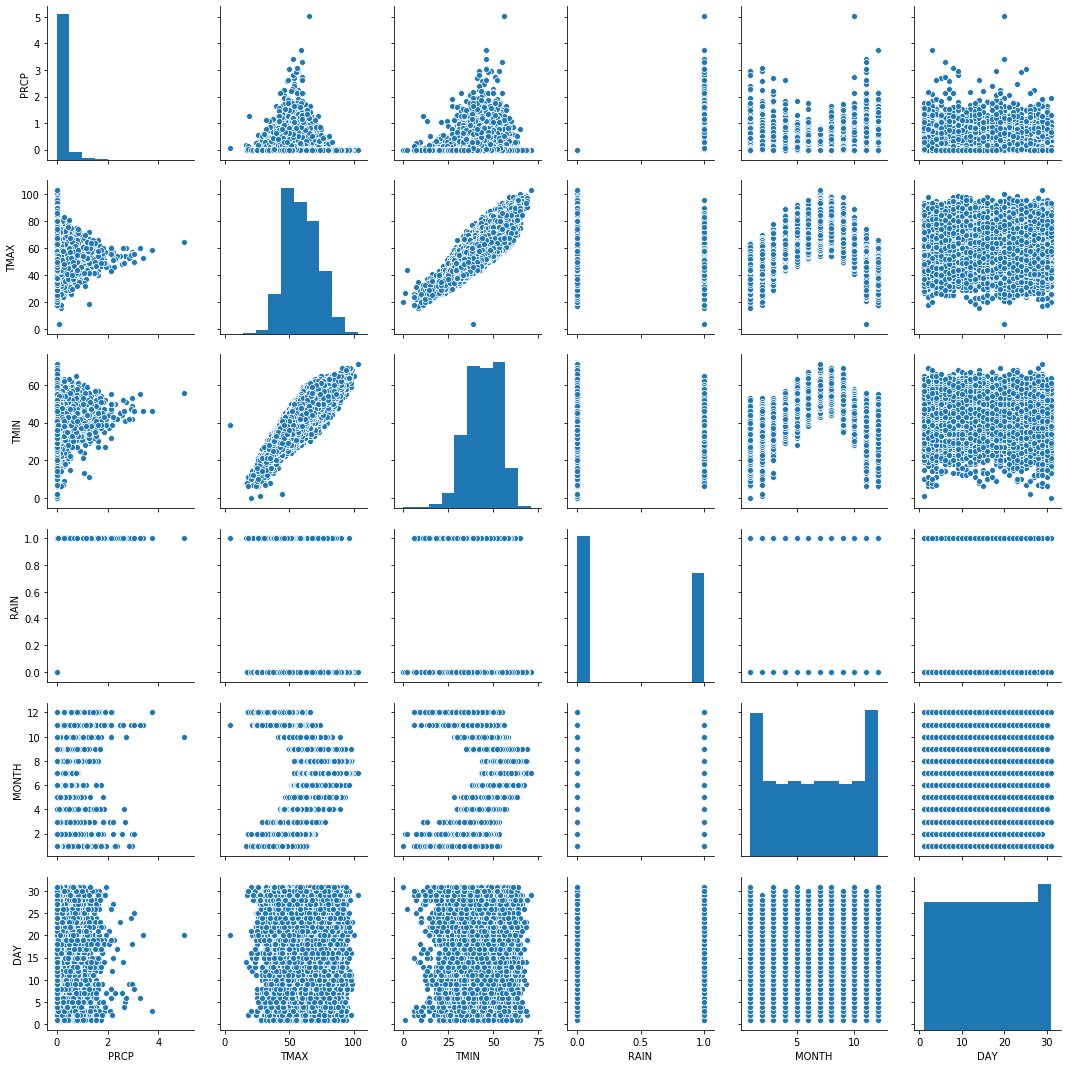

In [27]:
# visualize it
sns.pairplot(weather_df)#(data=data[['PRCP','TMAX','TMIN','MONTH','DAY']])

From the above correlation plots between variables, we can probably build some working models for a rain classifier.

### 2. Binary Classifiers

In [157]:
# Prepare the data
from sklearn.model_selection import train_test_split
X = weather_df[['TMAX','TMIN','MONTH','DAY']]
y= weather_df['RAIN']
X_scaled = preprocessing.scale(X)
X_train, X_test, y_train, y_test=train_test_split(X_scaled,y,test_size=0.2)

#### 2.1 Naive Bayes

In [152]:
# For Naive Bayes, we should remove variables that are highly correlated to avoid double counting. In this case, I'm combining TMAX and TMIN
# weather_df['TMEAN']=(weather_df['TMIN']+weather_df['TMAX'])/2
# X_nb=weather_df[['TMEAN','MONTH','DAY']]
# X_scaled = preprocessing.scale(X_nb)
# X_train, X_test, y_train, y_test=train_test_split(X_scaled,y,test_size=0.2)

In [158]:
from sklearn.naive_bayes import GaussianNB
# Assume the likelihood of the features is Gaussian
from sklearn import metrics

naive = GaussianNB()
naive.fit(X_train,y_train)
y_predicted_nb = naive.predict(X_test)
metrics.accuracy_score(y_test,y_predicted_nb)

0.6583838779103893

In [159]:
metrics.precision_score(y_test,y_predicted_nb)

0.577542062911485

In [160]:
metrics.recall_score(y_test,y_predicted_nb)

0.7276497695852534

In [161]:
metrics.confusion_matrix(y_test,y_predicted_nb)

array([[1786, 1155],
       [ 591, 1579]])

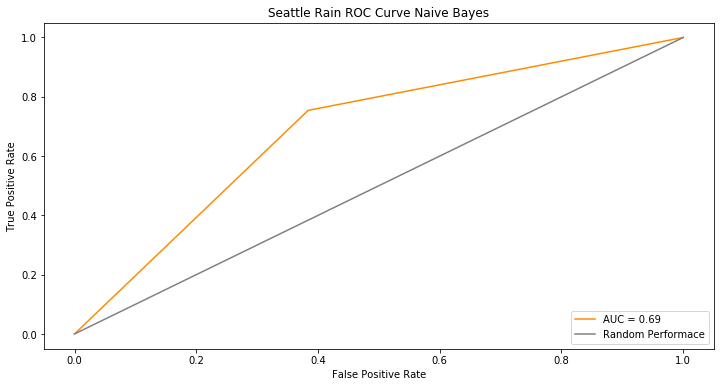

In [55]:
plot_roc(y_test,y_predicted_nb, 'Naive Bayes')

#### 2.2 Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_predicted_lr = lr.predict(X_test)
metrics.accuracy_score(y_test,y_predicted_lr)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7552338094306398

In [48]:
metrics.precision_score(y_test,y_predicted_lr)

0.7056721750781599

In [50]:
metrics.recall_score(y_test,y_predicted_lr)

0.7274401473296501

In [51]:
metrics.confusion_matrix(y_test,y_predicted_lr)

array([[2280,  659],
       [ 592, 1580]])

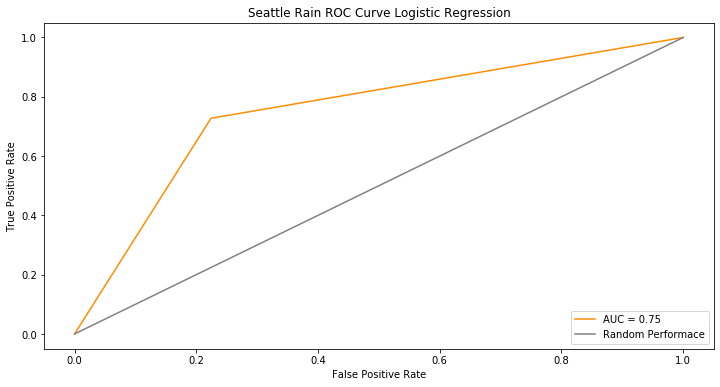

In [56]:
plot_roc(y_test,y_predicted_lr,'Logistic Regression')

#### 2.3 Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_predicted_rfc = rfc.predict(X_test)
metrics.accuracy_score(y_test,y_predicted_rfc)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.729211504597926

In [60]:
metrics.precision_score(y_test,y_predicted_rfc)

0.6839402427637722

In [61]:
metrics.recall_score(y_test,y_predicted_rfc)

0.6744935543278084

In [63]:
metrics.confusion_matrix(y_test,y_predicted_rfc)

array([[2262,  677],
       [ 707, 1465]])

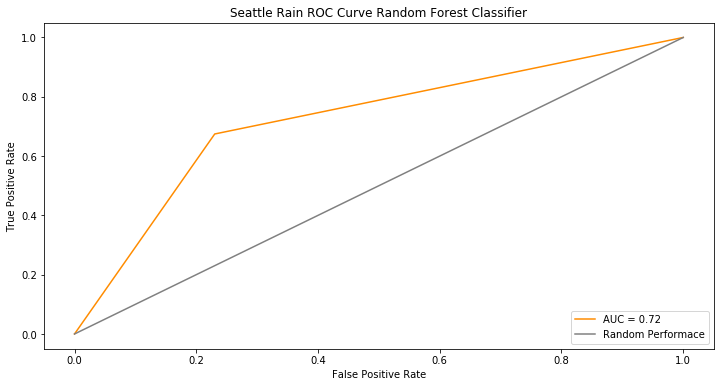

In [64]:
plot_roc(y_test,y_predicted_rfc,'Random Forest Classifier')

#### 2.4 SVM

In [66]:
from sklearn.svm import SVC, LinearSVC
svc = SVC()
svc.fit(X_train,y_train)
y_predicted_svc = svc.predict(X_test)
metrics.accuracy_score(y_test,y_predicted_svc)

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7714732928976716

In [67]:
precision_score = metrics.precision_score(y_test,y_predicted_svc)
recall_score = metrics.recall_score(y_test,y_predicted_svc)
print('Precision: {}; Recall: {}'.format(precision_score,recall_score))

Precision: 0.7105704697986577; Recall: 0.7799263351749539


In [68]:
metrics.confusion_matrix(y_test,y_predicted_svc)

array([[2249,  690],
       [ 478, 1694]])

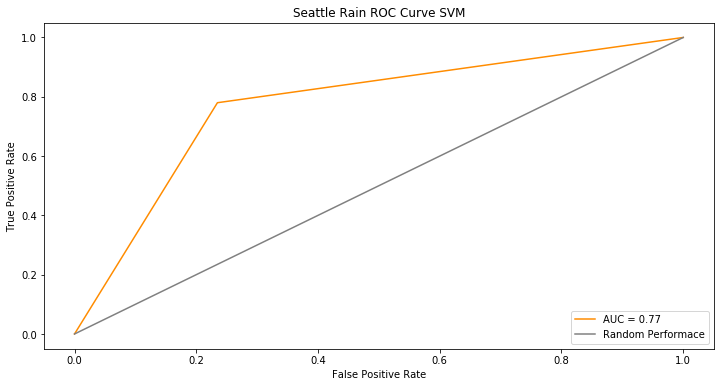

In [70]:
plot_roc(y_test,y_predicted_svc, 'SVM')

#### 2.5 Neural Network

In [150]:
nn_model=tf.keras.Sequential()
nn_model.add(Dense(16, activation='relu',input_shape=(4,)))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(8, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [93]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [151]:
history = nn_model.fit(X_train,y_train, batch_size=16, nb_epoch=50,validation_data=(X_test,y_test),verbose= 1)

Train on 20440 samples, validate on 5111 samples
Epoch 1/50
20440/20440 [==============================] - 2s 108us/sample - loss: 0.5092 - accuracy: 0.7533 - val_loss: 0.4813 - val_accuracy: 0.7650
Epoch 2/50
20440/20440 [==============================] - 2s 100us/sample - loss: 0.4835 - accuracy: 0.7647 - val_loss: 0.4804 - val_accuracy: 0.7693
Epoch 3/50
20440/20440 [==============================] - 2s 89us/sample - loss: 0.4817 - accuracy: 0.7653 - val_loss: 0.4795 - val_accuracy: 0.7697
Epoch 4/50
20440/20440 [==============================] - 2s 87us/sample - loss: 0.4808 - accuracy: 0.7660 - val_loss: 0.4776 - val_accuracy: 0.7674
Epoch 5/50
20440/20440 [==============================] - 2s 101us/sample - loss: 0.4794 - accuracy: 0.7690 - val_loss: 0.4790 - val_accuracy: 0.7676
Epoch 6/50
20440/20440 [==============================] - 2s 105us/sample - loss: 0.4786 - accuracy: 0.7657 - val_loss: 0.4769 - val_accuracy: 0.7678
Epoch 7/50
20440/20440 [=============================

In [78]:
def plot_loss_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

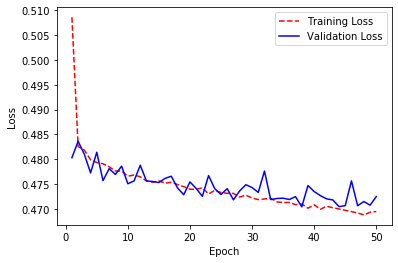

In [143]:
plot_loss_history(history)

In [146]:
y_predicted_nn=nn_model.predict(X_test)
y_predicted_nn=[1 if x>=0.55 else 0 for x in y_predicted_nn]
metrics.accuracy_score(y_test,y_predicted_nn)

0.778321267853649

In [147]:
precision_score = metrics.precision_score(y_test,y_predicted_nn)
recall_score = metrics.recall_score(y_test,y_predicted_nn)
print('Precision: {}; Recall: {}'.format(precision_score,recall_score))

Precision: 0.7324384787472036; Recall: 0.753683241252302


In [148]:
metrics.confusion_matrix(y_test,y_predicted_nn)

array([[2341,  598],
       [ 535, 1637]])

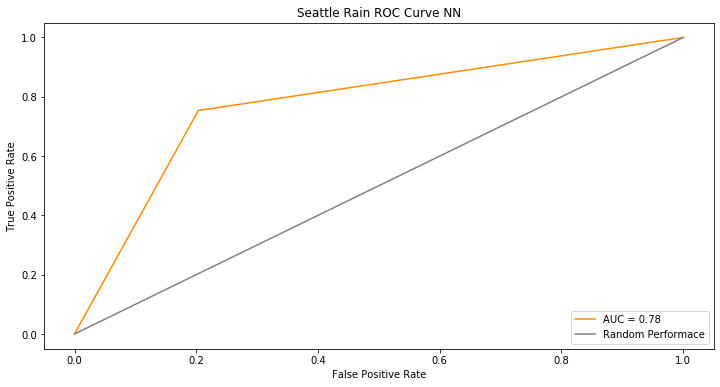

In [149]:
plot_roc(y_test,y_predicted_nn,'NN')

### 3. Univariate TS Forecast

#### 3.1 SARIMA

I really wanted to try using some flavor of SARIMA but did not managed to, because grid search on the parameters takes too long.
So this method does not fit into the timeline for solving this problem. But I still attached the code here.

In [169]:
import multiprocessing
from functools import partial
from contextlib import contextmanager

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()
    
# grid search configs
def grid_search(df, cfg_list, parallel=False):
    scores = None
    if parallel:
        # execute configs in parallel
        with poolcontext(processes=4) as pool:    
            scores = pool.map(partial(score_model, df), cfg_list) # pass full list (12 items)

    else:
        scores = [score_model(df, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [170]:
def score_model(df, cfg):
    aic = None
    # convert config to a key
    key = str(cfg)
    best_aic=2**20
    best_cfg=None
    try:
        # never show warnings when grid searching, too noisy
        with catch_warnings():
            filterwarnings("ignore")
            order, sorder = tuple(cfg[0:3]), tuple(cfg[3:])
            # define model
            model = SARIMAX(df.PRCP, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
            # fit model
            model_fit = model.fit(disp=False)
            aic=model_fit.aic
#             pred = model_fit.get_prediction(start=pd.to_datetime('2013-12-01'), dynamic=False)
#             predicted = pred.predicted_mean
#             truth=df['2013-12-01':]
#             result = measure_rmse(truth, predicted)
#                 _, result = walk_forward_validation(data, n_test, cfg)
    except:
        aic = None
    # check for an interesting result
    if aic is not None:
        print(' > Model[%s] AIC: %.3f' % (key, aic))
    return (key, aic)



#             with catch_warnings():
#                 filterwarnings("ignore")
#                 mod = SARIMAX(weather_df.PRCP,
#                             order=param,
#                             seasonal_order=param_seasonal,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)
#                 results = mod.fit()

#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
#             if results.aic<best_aic:
#                 best_aic=results.aic
#                 best_cfg = 'Config {}x{}'.format(param, param_seasonal)
#     #             print('Model improved with config {}x{}'.format(param, param_seasonal))

#     #         except:
#     #             continue
#     print('Best Model {} yields AIC: {}'.format(best_cfg, best_aic))

In [171]:
p = d = q = range(0, 3)
m = [30,90,180,365]
cfg_list = list(product(p, d, q, p, d, q, m))

In [172]:
scores=grid_search(short_weather_df, cfg_list, parallel=True)

 > Model[(0, 0, 0, 0, 0, 0, 30)] AIC: 910.039
 > Model[(0, 0, 0, 0, 0, 0, 90)] AIC: 910.039
 > Model[(0, 0, 0, 0, 0, 0, 180)] AIC: 910.039
 > Model[(0, 0, 0, 0, 0, 0, 365)] AIC: 910.039
 > Model[(0, 0, 0, 0, 0, 1, 30)] AIC: 781.528
 > Model[(0, 0, 0, 0, 0, 1, 90)] AIC: 834.470
 > Model[(0, 0, 0, 0, 0, 1, 180)] AIC: 876.178
 > Model[(0, 1, 0, 1, 0, 1, 180)] AIC: 1216.523


KeyboardInterrupt: 

Then I will pick the best config with the lowest AIC from the above execution from grid search.

#### 3.2 Vanilla LSTM

In [ ]:
# Prepare the data
